# Homework 2: Image Classification

## Load Modules

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# data
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import pickle
import os

# visualization
from tqdm import tqdm # progress bar
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Load ResNet18

In [2]:
np.random.seed(0)
torch.manual_seed(0)
model = resnet18(pretrained=True)
# 5 classes
model.fc = nn.Linear(512, 5)

/opt/homebrew/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load Data

In [3]:

# Open the attribute dictionary
with open("biased_cars_1/att_dict_simplified.p", "rb") as f:
    att_dict = pickle.load(f)

train_dataset = []
test_dataset = []

# Get the train and test data
folder_names = os.listdir("biased_cars_1/data")
folder_names = [x for x in folder_names if x != ".DS_Store"]

count = 0
for folder in tqdm(folder_names):
    for split in ["train", "test"]:
        path = "biased_cars_1/data/" + folder + "/" + split + "/images"
        for file in os.listdir(path):
            if file.find("frame") != -1:
                count += 1
                image_path = path + "/" + file
                image = Image.open(image_path)
                try: 
                    label = att_dict[file][2]
                    if split == "train":
                        train_dataset.append((image, label))
                    else:
                        test_dataset.append((image, label))
                except: 
                    continue

# Create a custom dataset
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = transforms.ToTensor()(image)
        return image, label

train_dataset = CarDataset(train_dataset)
test_dataset = CarDataset(test_dataset)

# Print the number of images in the train and test set
print("Number of images in the train set: ", len(train_dataset))

100%|██████████| 10/10 [00:01<00:00,  7.95it/s]

Number of images in the train set:  6779


## Show Images

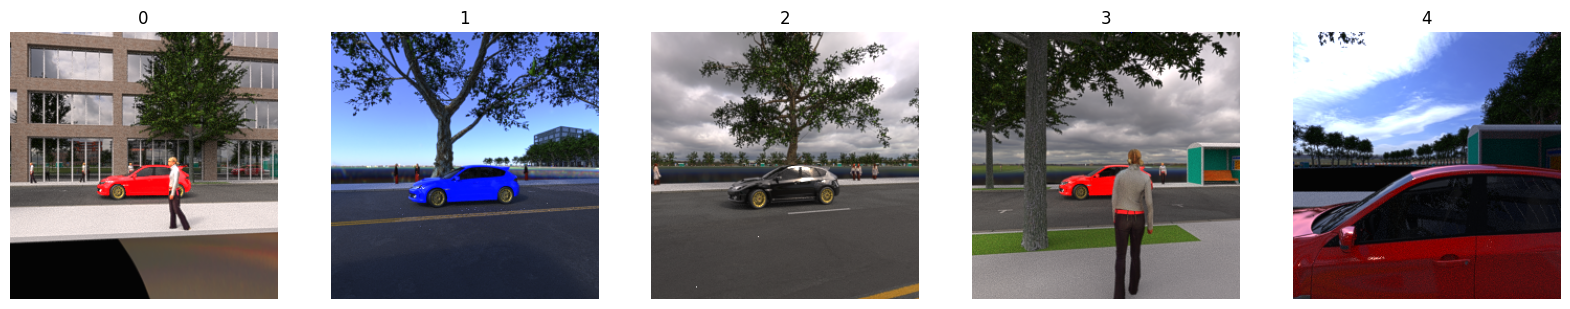

In [3]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    image, label = train_dataset[i]
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].set_title(i)
    ax[i].axis("off")

## Dataloaders

In [4]:
# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Train Model

100%|██████████| 212/212 [09:27<00:00,  2.67s/it]


Epoch 1/5, Train Loss: 0.1188, Test Loss: 0.0905, Train Acc: 0.9534, Test Acc: 0.9658


100%|██████████| 212/212 [09:11<00:00,  2.60s/it]


Epoch 2/5, Train Loss: 0.0644, Test Loss: 0.1138, Train Acc: 0.9733, Test Acc: 0.9630


100%|██████████| 212/212 [09:13<00:00,  2.61s/it]


Epoch 3/5, Train Loss: 0.0447, Test Loss: 0.0677, Train Acc: 0.9839, Test Acc: 0.9791


100%|██████████| 212/212 [11:35<00:00,  3.28s/it]


Epoch 4/5, Train Loss: 0.0319, Test Loss: 0.0468, Train Acc: 0.9891, Test Acc: 0.9810


100%|██████████| 212/212 [16:26<00:00,  4.65s/it] 


Epoch 5/5, Train Loss: 0.0216, Test Loss: 0.0452, Train Acc: 0.9925, Test Acc: 0.9839


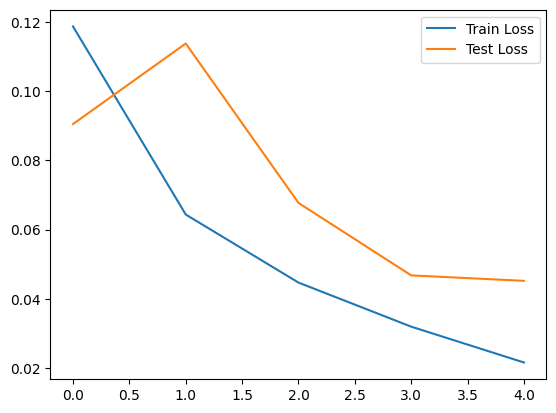

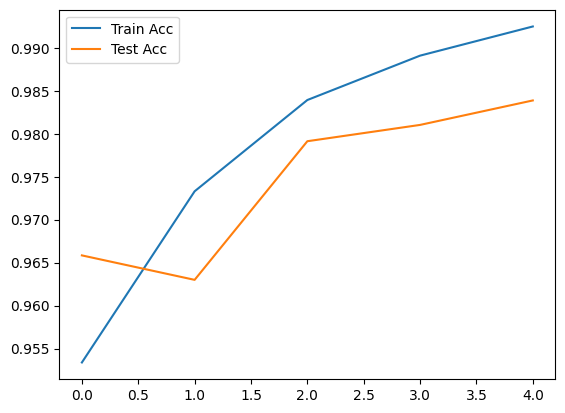

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

# Train the model for 5 epochs and populate the train_losses, test_losses, train_accs, and test_accs lists
for epoch in range(5):
    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0
    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += (outputs.argmax(1) == labels).sum().item()
    test_loss /= len(test_loader)
    test_acc /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch {epoch+1}/{5}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Plot the train and test losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

# Plot the train and test accuracies
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.legend()
plt.show()